# 数据集创建和整合

我们演示如何使用 `exprmat` 程序包进行单细胞 RNA 测序数据集的读取和整合。其他模态的数据读取步骤是类似的，
只是在元数据的指定上有所不同。

In [1]:
%load_ext autoreload
%autoreload 2

首先，导入程序包并设置工作目录：

In [2]:
import exprmat as em

# set working directory
em.setwd('/home/data/yangz/shared/tutorial')

你可以使用 `em.version` 和 `em.cuda` 这两个实用函数查看当前安装的包版本，注意包版本和数据库版本相对应。
当前的工作目录、配置的数据库目录会打印出来。使用 `em.memory` 可以查看当前实例占用的内存大小。 `em.cuda`
打印了可以使用的 GPU 列表信息

In [3]:
ver = em.version()

[i] exprmat 0.1.43 / exprmat-db 0.1.43
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/shared/tutorial
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.43)
[i] resident memory: 811.68 MiB
[i] virtual memory: 5.77 GiB


In [4]:
em.cuda()

[i] PyTorch version: 2.8.0+cu128
[i] GPU acceleration availability: YES
[i] CUDA version: 12.8
[i] Number of installed GPUs: 1
[i] Supporting BF16 format: YES
[i] Devices:
[i] [0] NVIDIA GeForce RTX 4090 D *
[i]     CUDA capability: (8, 9)
[i]     Installed VRAM (GiB): 47.38 GiB
[i]     Supporting TensorCore: YES
[i]     Current dedicated memory: 0.00 / 47.38 GiB (0.0%)


### 创建元数据表

创建元数据，我们指定了位于 `oe/filtered` 和 `wt/filtered` 路径下的两个表达矩阵，并将他们注册到 `rna` 模态，
我们还使用 `rna.splicing` 模态附加了 `velocyto` 程序输出的未剪接 RNA 矩阵。

In [5]:
meta = em.metadata(
    # two samples from a murine tumor infiltrating cd8+ t cell dataset.
    locations    = [
        'oe/filtered',
        'oe/velocyto/splicing.loom',
        'wt/filtered',
        'wt/velocyto/splicing.loom',
    ],
    modality     = ['rna', 'rna.splicing', 'rna', 'rna.splicing'],
    default_taxa = ['mmu', 'mmu', 'mmu', 'mmu'],
    batches      = ['b1', 'b1', 'b2', 'b2'],
    names        = ['oe', 'oe', 'wt', 'wt'],
    groups       = ['oe', 'oe', 'wt', 'wt']
)

我们可以获取元数据表

In [6]:
meta.dataframe

,location,sample,batch,group,modality,taxa
0,oe/filtered,oe,b1,oe,rna,mmu
1,oe/velocyto/splicing.loom,oe,b1,oe,rna.splicing,mmu
2,wt/filtered,wt,b2,wt,rna,mmu
3,wt/velocyto/splicing.loom,wt,b2,wt,rna.splicing,mmu


当我们确认元数据表没有错误，接下来传入 `em.experiment` 的构造函数中。第一个参数是元数据表，第二个参数告诉程序
将要默认把实验数据集保存的位置

In [7]:
expm = em.experiment(meta, dump = 'expm')

[i] reading sample oe [rna] ...


[i] 3 genes (out of 33696) not in the reference gene list.
[i] total 33693 genes mapped. 33693 unique genes.
[i] reading sample oe [rna.splicing] ...
[i] reading sample wt [rna] ...
[i] 3 genes (out of 33696) not in the reference gene list.
[i] total 33693 genes mapped. 33693 unique genes.
[i] reading sample wt [rna.splicing] ...


可以观察到，当前加载完成的数据集含有两个样本 `oe` 和 `wt`。因为 `rna.splicing` 模态不是独立的，他们只是将 loom 文件
中的表达矩阵附加到了相应的 `rna` 模态数据上。他们注册的物种信息、批次、和数据集大小均有显示。此时，数据集还没有整合，因此
在对象文本的开头会显示一个提示

In [8]:
expm

[!] dataset not integrated.
[*] composed of samples:
  oe   rna mmu    batch b1   of size 8999 × 33576
  wt   rna mmu    batch b2   of size 10738 × 33576


<exprmat.reader.experiment/39> (2 samples)

### 质量控制

接下来我们对数据及进行质量控制。单细胞 RNA 测序的质量控制的最初步骤是在各个样本中单独进行的。包括排除空液滴、筛选基因表达量过低的细胞、筛选线粒体转录本占比过高的细胞、并推断和去除双胞体。我们通过下面的方法可以对此进行控制。因为各个样本之间是独立的，在每个样本上进行相同的 QC 操作可以并行，我们提供了 `parallel` 参数进行多进程并行，这可以极大的提高处理速度（大约加快 5 倍左右）。然而，对于较少数量的样本，并行不能带来太大的获益，所以我们在这里使用同步的方式

In [9]:
expm.run_rna_qc(
    run_on_samples = True,
    mt_seqid = 'chrM',
    mt_percent = 0.15,
    ribo_genes = None,
    ribo_percent = None,
    outlier_mode = 'mads',
    outlier_n = 5,
    doublet_method = 'scrublet',
    min_cells = 3,
    min_genes = 800
)

[i] found 13 mitochondrial genes (expected 13)
[i] found 101 ribosomal genes
quality controlling sample [oe] ...
raw dataset contains 8999 cells, 33576 genes
[i] preprocessing observation count matrix ...
[i] simulating doublets ...
[i] embedding using pca ...
[i] calculating doublet scores ...
[i] detected doublet rate: 3.4 %
[i] estimated detectable doublet fraction: 69.6 %
[i] overall doublet rate: 4.9 %
filtered dataset contains 7039 cells, 19881 genes
[i] found 13 mitochondrial genes (expected 13)
[i] found 101 ribosomal genes
quality controlling sample [wt] ...
raw dataset contains 10738 cells, 33576 genes
[i] preprocessing observation count matrix ...
[i] simulating doublets ...
[i] embedding using pca ...
[i] calculating doublet scores ...
[i] detected doublet rate: 3.7 %
[i] estimated detectable doublet fraction: 63.9 %
[i] overall doublet rate: 5.8 %
filtered dataset contains 7908 cells, 19702 genes


Here, we will have a glance at the distribution of detected genes per cell.
Typically, this will be a zero-inflated normal distribution. The four marker lines
indicates 0, 100, 300 and 600 genes of the X axis.

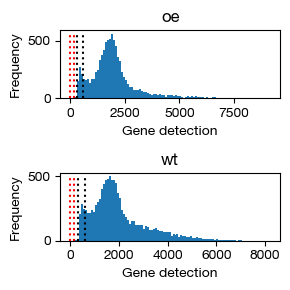

In [10]:
gene_counts = expm.plot_rna_qc_gene_counts(ncols = 1, figsize = (3, 3))

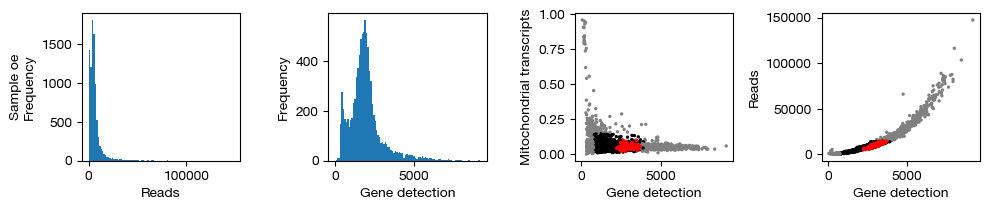

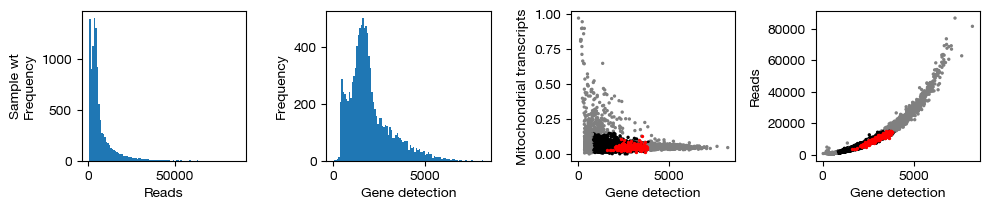

In [11]:
figs = expm.plot_rna_qc(run_on_samples = True)

最后，我们只保留选中的 QC 通过的细胞（上图中黑色的部分，红色部分是推断的双胞体，而灰色则是不符合基因、转录本数、线粒体转录本占比
而被筛除的细胞），这一步操作将永久的从各个样本中删除这些细胞，这个删除是不可逆的。我们不使用 `.raw` 保存未筛选的细胞

In [12]:
expm.save()
expm.run_rna_filter(run_on_samples = True)

### 分样本处理数据

对于细致的数据处理来说，我们需要先在单个样本水平上观察数据质量，排除异常的样本。

In [13]:
expm.run_rna_log_normalize(
    run_on_samples = True,
    key_norm = 'norm', 
    key_lognorm = 'lognorm'
)

In [14]:
expm.run_rna_select_hvg(
    run_on_samples = True,
    key_lognorm = 'lognorm',
    method = 'vst',
    dest = 'vst',
    n_top_genes = 2000
)

In [15]:
expm.run_rna_scale_pca(
    run_on_samples = True,
    hvg = 'vst.hvg',
    key_lognorm = 'lognorm',
    key_scaled = 'scaled',
    key_added = 'pca', n_comps = 35,
    keep_sparse = False,
    random_state = 42,
    svd_solver = 'arpack'
)

In [16]:
expm.run_rna_knn(
    run_on_samples = True,
    use_rep = 'pca',
    n_comps = None,
    n_neighbors = 30,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "euclidean",
    metric_kwds = {},
    random_state = 42,
    key_added = 'neighbors'
)

In [17]:
expm.run_rna_leiden(
    run_on_samples = True,
    resolution = 0.5,
    restrict_to = None,
    random_state = 42,
    key_added = 'leiden',
    adjacency = None,
    directed = None,
    use_weights = True,
    n_iterations = 2,
    partition_type = None,
    neighbors_key = None,
    obsp = None,
    flavor = 'igraph'
)

In [18]:
expm.run_rna_umap(
    run_on_samples = True,
    min_dist = 0.5,
    spread = 1,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 42,
    a = None, b = None,
    key_added = 'umap',
    neighbors_key = "neighbors"
)

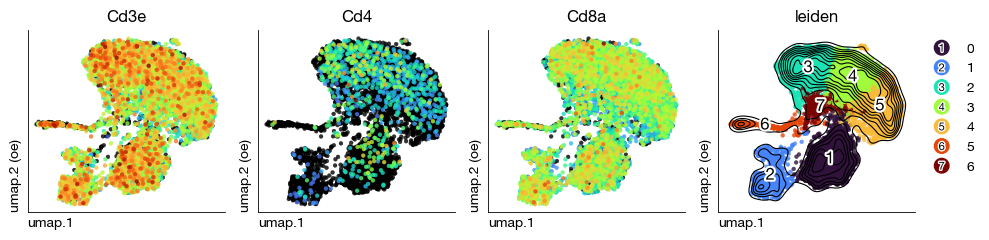

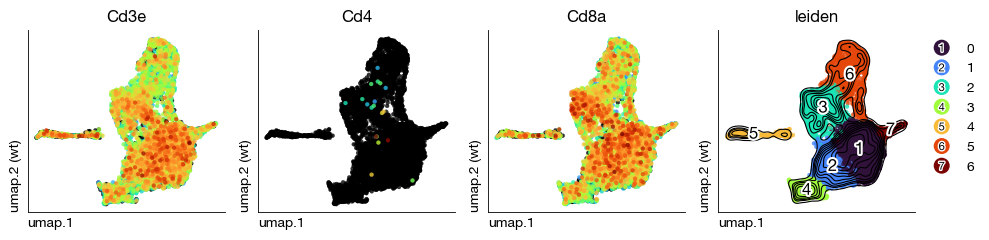

In [19]:
figs = expm.plot_rna_embedding_multiple(
    run_on_samples = True,
    basis = 'umap', features = ['Cd3e', 'Cd4', 'Cd8a', 'leiden'], ncols = 4,
    sort = True, figsize = (10, 2.5), dpi = 100
)

### 数据集整合

确认每个样本是合理无误之后，对数据进行整合。这将整合所有相同模块的样本，并汇总入一个大的 AnnData 对象中。
`expm.merge` 函数完成这个连接操作，而不改变任何读数。整合数据需要进一步批次校正，得到校正的嵌入表示

In [20]:
expm

[!] dataset not integrated.
[*] composed of samples:
  oe   rna mmu    batch b1   of size 7039 × 19881
  wt   rna mmu    batch b2   of size 7908 × 19702


<exprmat.reader.experiment/39> (2 samples)

In [21]:
expm.merge(
    join = 'outer',
    variable_columns = ['vst.hvg'],
    bool_merge_behavior = 'or'
)

In [22]:
expm.run_rna_scale_pca(
    hvg = 'vst.hvg',
    key_lognorm = 'X',
    key_scaled = 'scaled',
    key_added = 'pca', n_comps = 35,
    keep_sparse = False,
    random_state = 42,
    svd_solver = 'arpack'
)

In [23]:
expm

integrated dataset of size 14947 × 20899
contains modalities: rna

 modality [rna]
annotated data of size 14947 × 20899
    obs : sample batch group modality taxa barcode ubc n.umi n.genes n.mito n.ribo pct.mito pct.ribo
          filter score.doublet score.doublet.se is.doublet qc leiden
    var : chr start end strand id subtype gene tlen cdslen assembly uid vst.hvg
 layers : counts spliced unspliced ambiguous
   obsm : pca
   varm : pca
    uns : pca

[*] composed of samples:
  oe   rna mmu    batch b1   of size 7039 × 19881
  wt   rna mmu    batch b2   of size 7908 × 19702


<exprmat.reader.experiment/39> (2 samples)

In [24]:
expm.run_rna_integrate(
    method = 'harmony',
    basis = 'pca',
    dest = 'harmony'
)

2025-09-01 13:49:33,706 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-01 13:49:35,101 - harmonypy - INFO - sklearn.KMeans initialization complete.


In [25]:
expm.run_rna_knn(
    use_rep = 'harmony',
    n_comps = None,
    n_neighbors = 30,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "euclidean",
    metric_kwds = {},
    random_state = 42,
    key_added = 'neighbors'
)

In [26]:
expm.run_rna_leiden(
    resolution = 0.5,
    restrict_to = None,
    random_state = 42,
    key_added = 'leiden',
    adjacency = None,
    directed = None,
    use_weights = True,
    n_iterations = 2,
    partition_type = None,
    neighbors_key = None,
    obsp = None,
    flavor = 'igraph'
)

In [27]:
expm.run_rna_umap(
    min_dist = 0.5,
    spread = 1,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 42,
    a = None, b = None,
    key_added = 'umap',
    neighbors_key = "neighbors"
)

我们可以在整合的 UMAP 中可视化数据集的特征

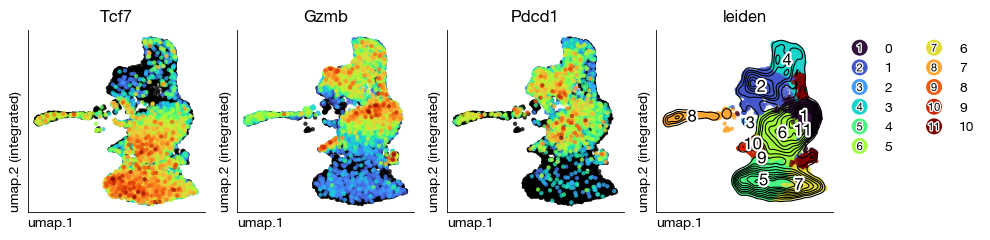

In [28]:
fig = expm.plot_rna_embedding_multiple(
    basis = 'umap', features = ['Tcf7', 'Gzmb', 'Pdcd1', 'leiden'], ncols = 4,
    sort = True, figsize = (10, 2.5), dpi = 100, legend_col = 2
)

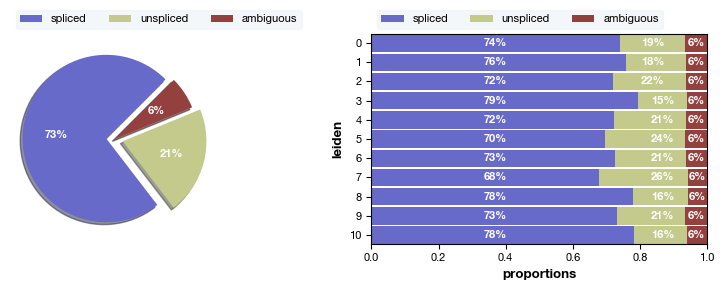

In [29]:
fig = expm.plot_rna_spliced_proportions(figsize = (8, 3))

In [30]:
expm

integrated dataset of size 14947 × 20899
contains modalities: rna

 modality [rna]
annotated data of size 14947 × 20899
    obs : sample batch group modality taxa barcode ubc n.umi n.genes n.mito n.ribo pct.mito pct.ribo
          filter score.doublet score.doublet.se is.doublet qc leiden
    var : chr start end strand id subtype gene tlen cdslen assembly uid vst.hvg
 layers : counts spliced unspliced ambiguous
   obsm : pca harmony knn knn.d umap
   varm : pca
   obsp : connectivities distances
    uns : pca neighbors leiden umap leiden.colors

[*] composed of samples:
  oe   rna mmu    batch b1   of size 7039 × 19881
  wt   rna mmu    batch b2   of size 7908 × 19702


<exprmat.reader.experiment/39> (2 samples)

### 保存数据集

保存数据集，如果指定 `save_samples` 参数为 False，我们将不保存样本的分数据集，而只保存整合后的数据。
这可以节省许多时间，或者当你不想让某些新的修改覆盖掉之前已经保存的样本。但是，我们建议你至少保存一个版本的样本数据，
它们在之后可能有用，而且可以避免重复的 QC 操作。

In [31]:
expm.save(save_samples = False)

[i] main dataset write to expm/integrated.h5mu


In [32]:
em.memory()

[i] resident memory: 3.31 GiB
[i] virtual memory: 86.78 GiB
